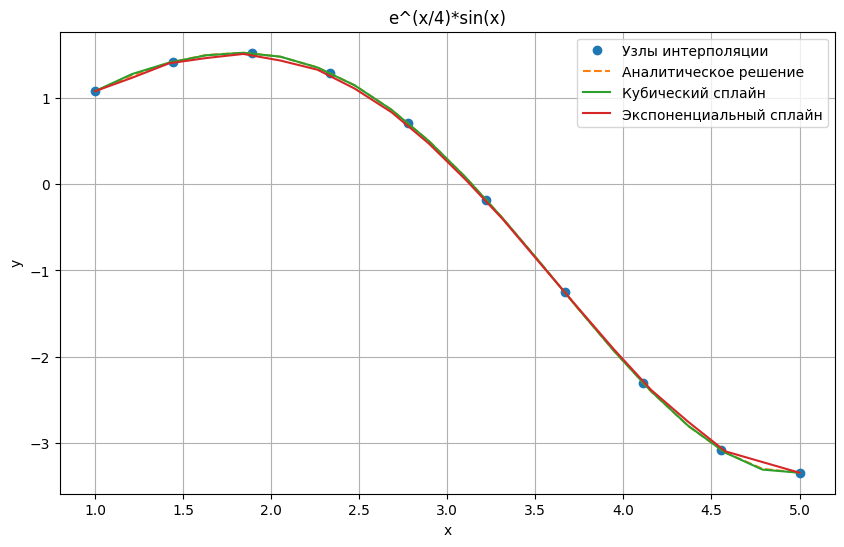

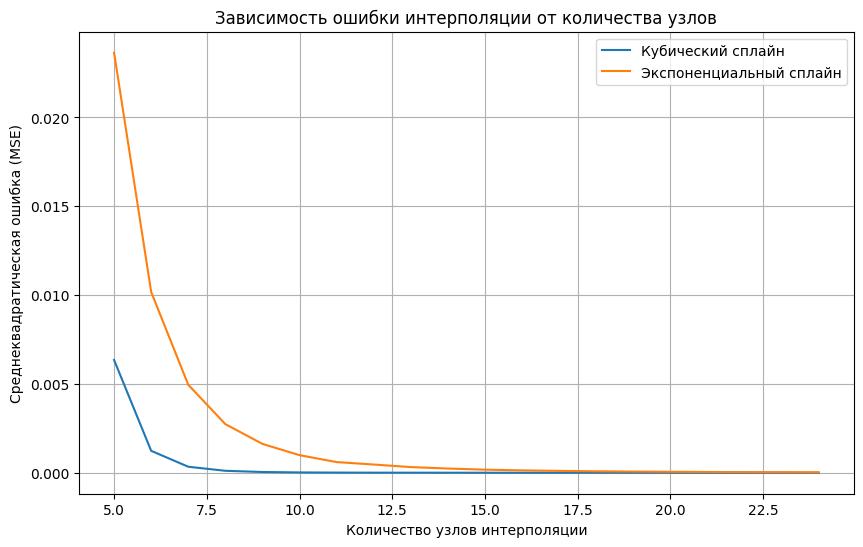

Средняя MSE для кубического сплайна: 0.0004
Средняя MSE для экспоненциального сплайна: 0.0023


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import solve_banded

# ------------------------------ Кубические сплайны ------------------------------
def cubic_spline_coeffs(x, y):
    """
    Рассчитывает коэффициенты кубического сплайна с "not-a-knot" условиями.
    """
    n = len(x) - 1
    h = np.diff(x)

    # Матрица для решения системы
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)

    # Заполнение матрицы для внутренних узлов
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]
        b[i] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1])

    # "Not-a-knot" граничные условия (третьи производные)
    A[0, 0] = h[0] + h[1]
    A[0, 1] = -h[0]
    b[0] = 3* h[1] * ((y[2] - y[1])/ h[1] - (y[1] - y[0])/ h[0])

    A[n, n-1] = -h[n-1]
    A[n, n] = h[n-2] + h[n-1]
    b[n] = 3* h[n-2] * ((y[n] - y[n-1])/ h[n-1] - (y[n-1] - y[n-2])/ h[n-2])



    # Решаем систему
    c = np.linalg.solve(A, b)

    # Вычисляем коэффициенты a, b, d
    a = (c[1:] - c[:-1]) / (3 * h)
    b_coeffs = (y[1:] - y[:-1]) / h - h * (2 * c[:-1] + c[1:]) / 3
    d = y[:-1]

    return a, c[:-1], b_coeffs, d

def evaluate_cubic_spline(x, coeffs, x_eval):
    """
    Вычисляет значения кубического сплайна.
    """
    a, c, b, d = coeffs
    y_eval = []
    for xi in x_eval:
        for i in range(len(x) - 1):
            if x[i] <= xi <= x[i + 1]:
                dx = xi - x[i]
                y = a[i] * dx**3 + c[i] * dx**2 + b[i] * dx + d[i]
                y_eval.append(y)
                break
    return np.array(y_eval)

# ------------------------------ Экспоненциальные сплайны ------------------------------

def exp_spline_coeffs(x, y):
    """
    Рассчитывает коэффициенты (a_i, b_i, c_i, d_i) для экспоненциальных сплайнов с "not-a-knot" условиями.
    """
    n = len(x) - 1
    coeffs = []

    for i in range(n):
        # Начальные приближения для оптимизации
        a0, b0, c0, d0 = 1.0, 0.1, 0.0, 0.0

        def objective(params):
            a, b, c, d = params
            x0, x1 = x[i], x[i + 1]
            y0, y1 = y[i], y[i + 1]
            # Условия интерполяции в концах сегмента
            f_x0 = a * np.exp(b * x0) + c * x0 + d
            f_x1 = a * np.exp(b * x1) + c * x1 + d

            # Условия "not-a-knot" если мы на границах
            not_a_knot_term = 0
            if i == 0 and n > 1:
                if len(coeffs) > i+1:
                  a_next, b_next, _, _ = coeffs[i+1]
                  not_a_knot_term = ((a * b**3 * np.exp(b*x[1])) - (a_next * b_next**3 * np.exp(b_next*x[1])))**2

            elif i == n - 2 and n > 2:
              if len(coeffs) > i - 1:
                a_prev, b_prev, _, _ = coeffs[i-1]
                a_curr, b_curr, _, _ = params
                not_a_knot_term = ((a_prev*b_prev**3 * np.exp(b_prev*x[-2])) - (a_curr*b_curr**3* np.exp(b_curr*x[-2])))**2

            return (f_x0 - y0)**2 + (f_x1 - y1)**2 + not_a_knot_term

        # Оптимизация коэффициентов
        res = minimize(objective, [a0, b0, c0, d0])
        coeffs.append(res.x)

    return coeffs

def evaluate_exp_spline(x, coeffs, X):
    """
    Вычисляет значения экспоненциального сплайна.
    """
    y_spline = np.zeros_like(X)

    for i, xi in enumerate(X):
        for j in range(len(x) - 1):
            if x[j] <= xi <= x[j + 1]:
                a, b, c, d = coeffs[j]
                y_spline[i] = a * np.exp(b * xi) + c * xi + d
                break

    return y_spline

# ------------------------------ Функции для вычисления ошибки ------------------------------
def calculate_error(y_true, y_approx):
    """
    Вычисляет среднеквадратическую ошибку (MSE), деля на n.
    """
    n = len(y_true)
    return np.sum((y_approx - y_true)**2) / n



# ------------------------------ Тестирование ------------------------------

if __name__ == '__main__':
    # Определяем функцию
    def target_function(x):
      return np.exp(x/4)*np.sin(x)

    # Задаем интервал и количество точек
    a, b = 1, 5  # Интервал для x
    num_points = 10 # количество точек
    x = np.linspace(a, b, num_points)
    y = target_function(x) # Теперь y генерируется с помощью нашей функции
    x_eval = np.linspace(a, b, 20)
    y_true = target_function(x_eval)  # Истинные значения для оценки ошибки

    # --- Кубический сплайн ---
    cubic_coeffs = cubic_spline_coeffs(x, y)
    y_cubic_eval = evaluate_cubic_spline(x, cubic_coeffs, x_eval)

    # --- Экспоненциальный сплайн ---
    exp_coeffs = exp_spline_coeffs(x, y)
    y_exp_eval = evaluate_exp_spline(x, exp_coeffs, x_eval)

    # --- Визуализация интерполяции ---
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o', label='Узлы интерполяции')
    plt.plot(x_eval, y_true, label='Аналитическое решение', linestyle = '--')
    plt.plot(x_eval, y_cubic_eval, label='Кубический сплайн')
    plt.plot(x_eval, y_exp_eval, label='Экспоненциальный сплайн')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('e^(x/4)*sin(x)')
    plt.grid(True)
    plt.show()

    # --- Расчет и отображение графика ошибок ---
    num_points_list = range(5, 25)  # Количество точек для итерации
    cubic_errors = []
    exp_errors = []

    # Вычисление ошибок
    for num_points in num_points_list:
      # Генерируем точки x и y = f(x)
      x = np.linspace(a, b, num_points)
      y = target_function(x)
      x_eval = np.linspace(a, b, 100)
      y_true = target_function(x_eval)

      # --- Кубический сплайн ---
      cubic_coeffs = cubic_spline_coeffs(x, y)
      y_cubic_eval = evaluate_cubic_spline(x, cubic_coeffs, x_eval)

      # --- Экспоненциальный сплайн ---
      exp_coeffs = exp_spline_coeffs(x, y)
      y_exp_eval = evaluate_exp_spline(x, exp_coeffs, x_eval)

      # --- Вычисление ошибок ---
      cubic_error = calculate_error(y_true, y_cubic_eval)
      exp_error = calculate_error(y_true, y_exp_eval)

      cubic_errors.append(cubic_error)
      exp_errors.append(exp_error)

    # --- Усреднение ошибок ---
    avg_cubic_error = np.mean(cubic_errors)
    avg_exp_error = np.mean(exp_errors)

    # --- Визуализация зависимости ошибки от количества узлов ---
    plt.figure(figsize=(10, 6))
    plt.plot(num_points_list, cubic_errors, label='Кубический сплайн')
    plt.plot(num_points_list, exp_errors, label='Экспоненциальный сплайн')
    plt.xlabel('Количество узлов интерполяции')
    plt.ylabel('Среднеквадратическая ошибка (MSE)')
    plt.legend()
    plt.title('Зависимость ошибки интерполяции от количества узлов')
    plt.grid(True)
    plt.show()

    print(f"Средняя MSE для кубического сплайна: {avg_cubic_error:.4f}")
    print(f"Средняя MSE для экспоненциального сплайна: {avg_exp_error:.4f}")